In [136]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

import torch

# Utility functions

In [137]:
def normalize(X, y):
    means = torch.mean(X, axis=0)
    stdevs = torch.std(X, axis=0)
    X = (X - means)/ stdevs
    y = (y - means)/ stdevs
    return X, y


def split_data(X, y, ratio=(0.7, 0.2)):
    """
    Splits data in a given episode. Not used in the final submission.
    """
    
    assert sum(ratio) < 1., 'Ratio arg invalid. You need to define a split to allow for test samples.'
    
    num_samples = X.shape[0]
    indices = torch.randperm(X.shape[0])
    tr_idx = int(num_samples*ratio[0])
    dev_idx = int(num_samples*ratio[1])
    print(f'Training id and dev id: {tr_idx}, {dev_idx}')
    
    training_X = X[indices[:tr_idx]]
    training_y = y[indices[:tr_idx]]
    dev_X = X[indices[tr_idx:tr_idx+dev_idx]]
    dev_y = y[indices[tr_idx:tr_idx+dev_idx]]
    test_X = X[indices[tr_idx+dev_idx:]]
    test_y = y[indices[tr_idx+dev_idx:]]
    
    print(f'Created {len(training_X)} training, {len(dev_X)}, dev and {len(test_X)} test samples')
    
    return (
        (training_X, training_y),
        (dev_X, dev_y),
        (test_X, test_y)
    )
    
    
def split_by_episodes(data, ratio=(0.5, 0.5)):
    """
    Splits by episodes. This is used for the below experiments.
    """
    
    
    num_samples = len(data)
    indices = torch.randperm(num_samples)
    
    tr_idx = int((num_samples-10)*ratio[0])
    dev_idx = int((num_samples-10)*ratio[1])
    
    print(f'Training id and dev id: {tr_idx}, {dev_idx}')
    
    training = data[indices[:tr_idx]]
    dev = data[indices[tr_idx:tr_idx+dev_idx]]
    test = data[indices[tr_idx+dev_idx:]]
    
    print(f'Created {len(training)} training, {len(dev)} dev and {len(test)} test samples')
    
    return ( 
        training, dev, test
    )


# Dynamics Prediction Model

In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(
            self,
            state_dim=6
    ):
        super(Model, self).__init__()
        self.model = nn.Linear(state_dim, state_dim)

    def forward(self, state):
        next_state = self.model(state)
        return next_state

    
class Trainer():
    
    def __init__(self, state_dim=6, eta=1e-3, epochs=10, batch_size=128):
        self.eta = eta
        self.epochs = epochs
        self.batch_size=batch_size
        self.model = Model(state_dim=state_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.eta)

    def prepare_data(self, episode_data):
        X, y = zip(*
            [(r['observation'], r['next_observation']) for r in episode_data if r['next_observation'] != None]
        )
        X = torch.tensor(X)
        y = torch.tensor(y)        
        perm = torch.randperm(X.shape[0])
        X = X[perm]
        y = y[perm]
        
        batches = []
        num_batches = X.shape[0] // self.batch_size
        for batch in range(num_batches):
            
            batch = (
                X[batch*self.batch_size: (batch+1)*self.batch_size],
                y[batch*self.batch_size: (batch+1)*self.batch_size]
            )
            batches.append(batch)
        
        return batches
        
    def eval_on_dev(self, dev):
        self.model.eval()
        dev_losses = 0
        counter = 0
        
        for episode in range(len(dev)):
            batches = self.prepare_data(dev[episode])
            
            for b in batches:
                states, next_states = b[0], b[1]
                pred_next_states = self.model(states)
                curr_loss = F.mse_loss(pred_next_states, next_states)
                dev_losses += curr_loss.item()
                counter += states.shape[0]
            
        self.model.train()
        return dev_losses / counter
        
        
    def train(self, tr_data, dev_data, save_path='q2_models/'):
        
        if not os.path.exists(save_path):
            print(f'Creating {save_path}')
            os.makedirs(save_path)
        
        epoch_losses = []
        val_losses = []
        
        for e in range(self.epochs):    
            epoch_loss = 0
            counter = 0
            
            for episode in range(len(tr_data)):
                curr_data = self.prepare_data(tr_data[episode])
                
                num_batches = len(curr_data)
                for idx in range(num_batches):

                    # actual trajectory
                    states, next_states = curr_data[idx][0], curr_data[idx][1]
                    
                    pred_next_states = self.model(states)
                    curr_loss = F.mse_loss(pred_next_states, next_states)
                    
                    self.optimizer.zero_grad()
                    curr_loss.backward()
                    self.optimizer.step()
                    epoch_loss += curr_loss
                    counter += states.shape[0]
                    
            epoch_losses.append(epoch_loss / counter)
                                      
            print(f'Epoch {e} training MSE: {epoch_losses[-1]}')
            val_loss = self.eval_on_dev(dev)
            print(f'Epoch {e} validation MSE: {val_loss}')
            val_losses.append(val_loss)
            
            # save model
            if save_path:
                self.save(self.optimizer, f"{save_path}/{e}")

        return epoch_losses, val_losses
    
    def save(self, optimizer, filename):
        torch.save(self.model.state_dict(), filename)
        torch.save(optimizer.state_dict(), filename)

    def load(self, optimizer, filename):
        self.model.load_state_dict(torch.load(filename))
        optimizer.load_state_dict(torch.load(filename))

# Read noisy dataset with epsilon 0.1

In [171]:
dataset = 'dataset_eps0.1.jsonl'

data = []

with open(dataset, 'r') as f:
    for d in f.readlines():
        data.append(json.loads(d))
data = np.array(data)

# Split into a given ratio to obtain train, dev and test

In [172]:
tr, dev, test = split_by_episodes(data, ratio=(0.5, 0.5))

Training id and dev id: 245, 245
Created 245 training, 245 dev and 10 test samples


# Set up Trainer object, and launch training

In [173]:
torch.manual_seed(0)
np.random.seed(0)
trainer = Trainer(batch_size=64, epochs=10)
tr_losses, val_losses = trainer.train(tr, dev)

Epoch 0 training MSE: 12.029426574707031
Epoch 0 validation MSE: 5.126540261216404
Epoch 1 training MSE: 4.449687480926514
Epoch 1 validation MSE: 4.047655215086949
Epoch 2 training MSE: 4.070590019226074
Epoch 2 validation MSE: 4.025349181696734
Epoch 3 training MSE: 4.048620223999023
Epoch 3 validation MSE: 3.994600624432413
Epoch 4 training MSE: 4.043342113494873
Epoch 4 validation MSE: 4.01218261585672
Epoch 5 training MSE: 4.059231758117676
Epoch 5 validation MSE: 3.9914941551646583
Epoch 6 training MSE: 4.055515289306641
Epoch 6 validation MSE: 3.9899925237491254
Epoch 7 training MSE: 4.039003849029541
Epoch 7 validation MSE: 3.989721564730586
Epoch 8 training MSE: 4.03566312789917
Epoch 8 validation MSE: 3.9913166588295006
Epoch 9 training MSE: 4.036798477172852
Epoch 9 validation MSE: 3.9764239172123763


# Plot training and validation losses over epochs

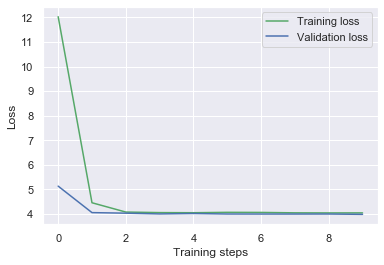

In [174]:
timestamps = np.arange(0,10)
plt.plot(timestamps, tr_losses, 'g', label='Training loss')
plt.plot(timestamps, val_losses, 'b', label='Validation loss')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [175]:
ls q2_models/*

q2_models/0  q2_models/2  q2_models/4  q2_models/6  q2_models/8
q2_models/1  q2_models/3  q2_models/5  q2_models/7  q2_models/9


# Predict trajectory for a given episode of the test set, and plot state transitions

In [178]:
# 50 episodes, each having various num of timestamps
episode_data = test[0]
X, y = zip(*
            [(r['observation'], r['next_observation']) for r in episode_data if r['next_observation'] != None]
        )
X = torch.tensor(X)
y = torch.tensor(y)        
X, y = normalize(X, y)
        
state_ids = [4,5]
    
results = []
curr_state = X[0]

for true_state, true_next_state in zip(X,y):
    next_states = trainer.model(curr_state)
    predictions = next_states[state_ids]

    results.append([curr_state[state_ids], true_state[state_ids]])
    curr_state = next_states.detach()


results[0]

[tensor([ 0.0242, -0.0145]), tensor([ 0.0242, -0.0145])]

In [179]:
num_timestamps = 500

predicted_x = [r[0][0].numpy() for r in results[:num_timestamps]]
predicted_Y = [r[0][1].numpy() for r in results[:num_timestamps]]

true_x = [r[1][0].numpy() for r in results[:num_timestamps]]
true_y = [r[1][1].numpy() for r in results[:num_timestamps]]



In [180]:
print(predicted_x[0], predicted_Y[0])
print(true_x[0], true_y[0])

0.024229512 -0.0145395445
0.024229512 -0.0145395445


In [181]:
start_point = predicted_x[0], predicted_Y[0]
start_point

(array(0.02422951, dtype=float32), array(-0.01453954, dtype=float32))

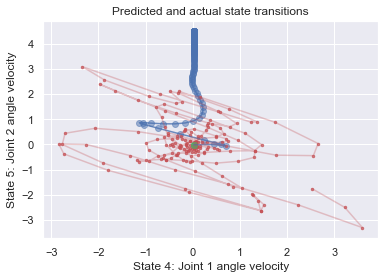

In [182]:
fig, ax = plt.subplots()

plt.scatter(predicted_x, predicted_Y, alpha=0.5)
plt.scatter(true_x, true_y, c="r", alpha=0.7, s=6)
plt.scatter(start_point[0], start_point[1], c='g')

plt.plot(predicted_x, predicted_Y, alpha=0.8)
plt.plot(true_x, true_y, c="r", alpha=0.3)
plt.scatter(start_point[0], start_point[1], c='g')

plt.title('Predicted and actual state transitions')
ax.set_xlabel('State 4: Joint 1 angle velocity')
ax.set_ylabel('State 5: Joint 2 angle velocity')
plt.show()




0.9707085096780512
0.0021602283


/Users/Dora/.pyenv/versions/3.7.3/envs/nlp/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


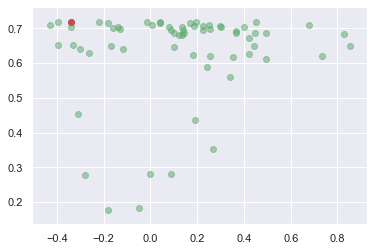

In [56]:
from sklearn.linear_model import LinearRegression


batches=trainer.prepare_data(tr[0])
X, y = batches[0][0], batches[0][1] 

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
out = reg.predict(X)
print(np.mean((out - y.numpy())**2))

batches=trainer.prepare_data(test[0])
X, y = batches[0][0], batches[0][1] 
out = reg.predict(X)
np.mean((out - y.numpy())**2)

predicted_x = []
predicted_y = []
true_x = []
true_y = []
curr = X[0].reshape(1,-1).numpy()

for sample, next in zip(X, y):
    pred = reg.predict(curr)
    predicted_x.append(curr[:,1])
    predicted_y.append(curr[:,2])
    true_x.append(sample[1].numpy().item())
    true_y.append(sample[2].numpy().item())
    curr = pred.reshape(1,-1)

start_point = true_x[0], true_y[0]

# plt.scatter(predicted_x, predicted_y, alpha=0.5)
plt.scatter(true_x, true_y, c="g", alpha=0.5)
plt.scatter(start_point[0], start_point[1], c='r')

plt.show()

